**References:** https://towardsdatascience.com/depth-estimation-on-camera-images-using-densenets-ac454caa893



**Import modules**

In [0]:
from IPython.display import Image
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
import PIL

**Install required modules**

In [2]:
!pip install keras pillow matplotlib scikit-learn scikit-image opencv-python pydot GraphViz

In [3]:
!git clone https://github.com/priya-dwivedi/Deep-Learning.git

fatal: destination path 'Deep-Learning' already exists and is not an empty directory.


In [4]:
%cd Deep-Learning/depth_estimation

/content/Deep-Learning/depth_estimation


**Download nyu v2 dataset**

In [5]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu_data.zip

--2019-12-26 09:14:13--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu_data.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.97.67
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.97.67|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4399138715 (4.1G) [application/zip]
Saving to: ‘nyu_data.zip.4’

nyu_data.zip.4      100%[===================>]   4.10G  21.3MB/s    in 3m 21s  

2019-12-26 09:17:34 (20.9 MB/s) - ‘nyu_data.zip.4’ saved [4399138715/4399138715]



**Download pre-trained weights from paper**

In [6]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5

--2019-12-26 09:17:36--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu.h5
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.57.123
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.57.123|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 172897376 (165M) [application/h5]
Saving to: ‘nyu.h5.4’

nyu.h5.4            100%[===================>] 164.89M  21.8MB/s    in 8.4s    

2019-12-26 09:17:45 (19.6 MB/s) - ‘nyu.h5.4’ saved [172897376/172897376]



**Extract downloaded nyu v2 dataset data**

In [0]:
#unzip test data to perform PCA on it in order to create new modified test datasets
#!unzip nyu_test.zip

**Perform PCA on test data to create new datasets**

In [8]:
# Load test data
print('Loading test data...', end='')
import numpy as np
from data import extract_zip
data = extract_zip('nyu_test.zip')
from io import BytesIO
rgb = np.load(BytesIO(data['eigen_test_rgb.npy']))
depth = np.load(BytesIO(data['eigen_test_depth.npy']))
crop = np.load(BytesIO(data['eigen_test_crop.npy']))

Loading test data...

Using TensorFlow backend.


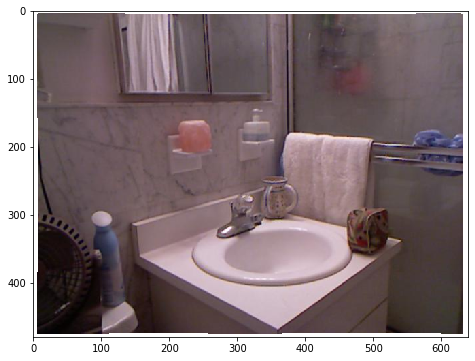

In [24]:
type(rgb)
#rgbmat.shape = (rgb.size[1], rgb.size[0])
plt.figure(figsize=(9, 6))
plt.imshow(rgb[0])
plt.show()

In [0]:
# Evaluate modle on baseline (unmodified images):
!python test.py --model ./nyu.h5

Using TensorFlow backend.
Loading model...
















In [62]:
# Iterate over all rgb images and replace 

rgb_img = PIL.Image.fromarray(rgb[0])

rgb_imgmat = np.array(list(rgb_img.getdata(band=0)), float)
print(rgb_imgmat.shape)

# Reshape according to orginal image dimensions
rgb_imgmat.shape = (rgb_img.size[1], rgb_img.size[0])

U, D, V = np.linalg.svd(rgb_imgmat)

for number_of_singular_values in [2,4,8,32,64,125,250,561]:
  if(number_of_singular_values < rgb_imgmat.shape[0]):
    #start = time.process_time()
    reconstimg = np.matrix(U[:, :number_of_singular_values]) * np.diag(D[:number_of_singular_values]) * np.matrix(V[:number_of_singular_values, :])
    plt.imshow(reconstimg, cmap='gray') #
    plt.title("Reconstruction with "+ str(number_of_singular_values))
    #plt.savefig('my_examples/test_IMG.jpg')
    plt.show()

#!python test.py --model ./nyu.h5
    #print("Time for execution: ",time.process_time() - start)
    # Copy result file to designated folder
    #shutil.copy2('results.png', 'result_folder/'+'result_with_'+str(number_of_singular_values)+'_components.png')

(480, 640, 3)
(307200,)


**Evaluate**

In [8]:
!wget https://s3-eu-west-1.amazonaws.com/densedepth/nyu_test.zip

--2019-12-26 07:02:30--  https://s3-eu-west-1.amazonaws.com/densedepth/nyu_test.zip
Resolving s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)... 52.218.110.115
Connecting to s3-eu-west-1.amazonaws.com (s3-eu-west-1.amazonaws.com)|52.218.110.115|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1406362472 (1.3G) [application/zip]
Saving to: ‘nyu_test.zip’

nyu_test.zip        100%[===================>]   1.31G  21.9MB/s    in 63s     

2019-12-26 07:03:34 (21.4 MB/s) - ‘nyu_test.zip’ saved [1406362472/1406362472]



In [9]:
!python evaluate.py --model ./nyu.h5

Using TensorFlow backend.
Loading model...














Loading test data...Test data loaded.

Testing...
        a1,         a2,         a3,        rel,        rms,     log_10
    0.8471,     0.9731,     0.9937,     0.1234,     0.4611,     0.0535
        a1,         a2,         a3,        rel,        rms,     log_10
    0.8471,     0.9731,     0.9937,     0.1234,     0.4611,     0.0535

Test time 105.32344031333923 s


**Visualize**

In [10]:
!python test.py --model ./nyu.h5

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (4) images of size (480, 640, 3).
It took:  28.679930925369263


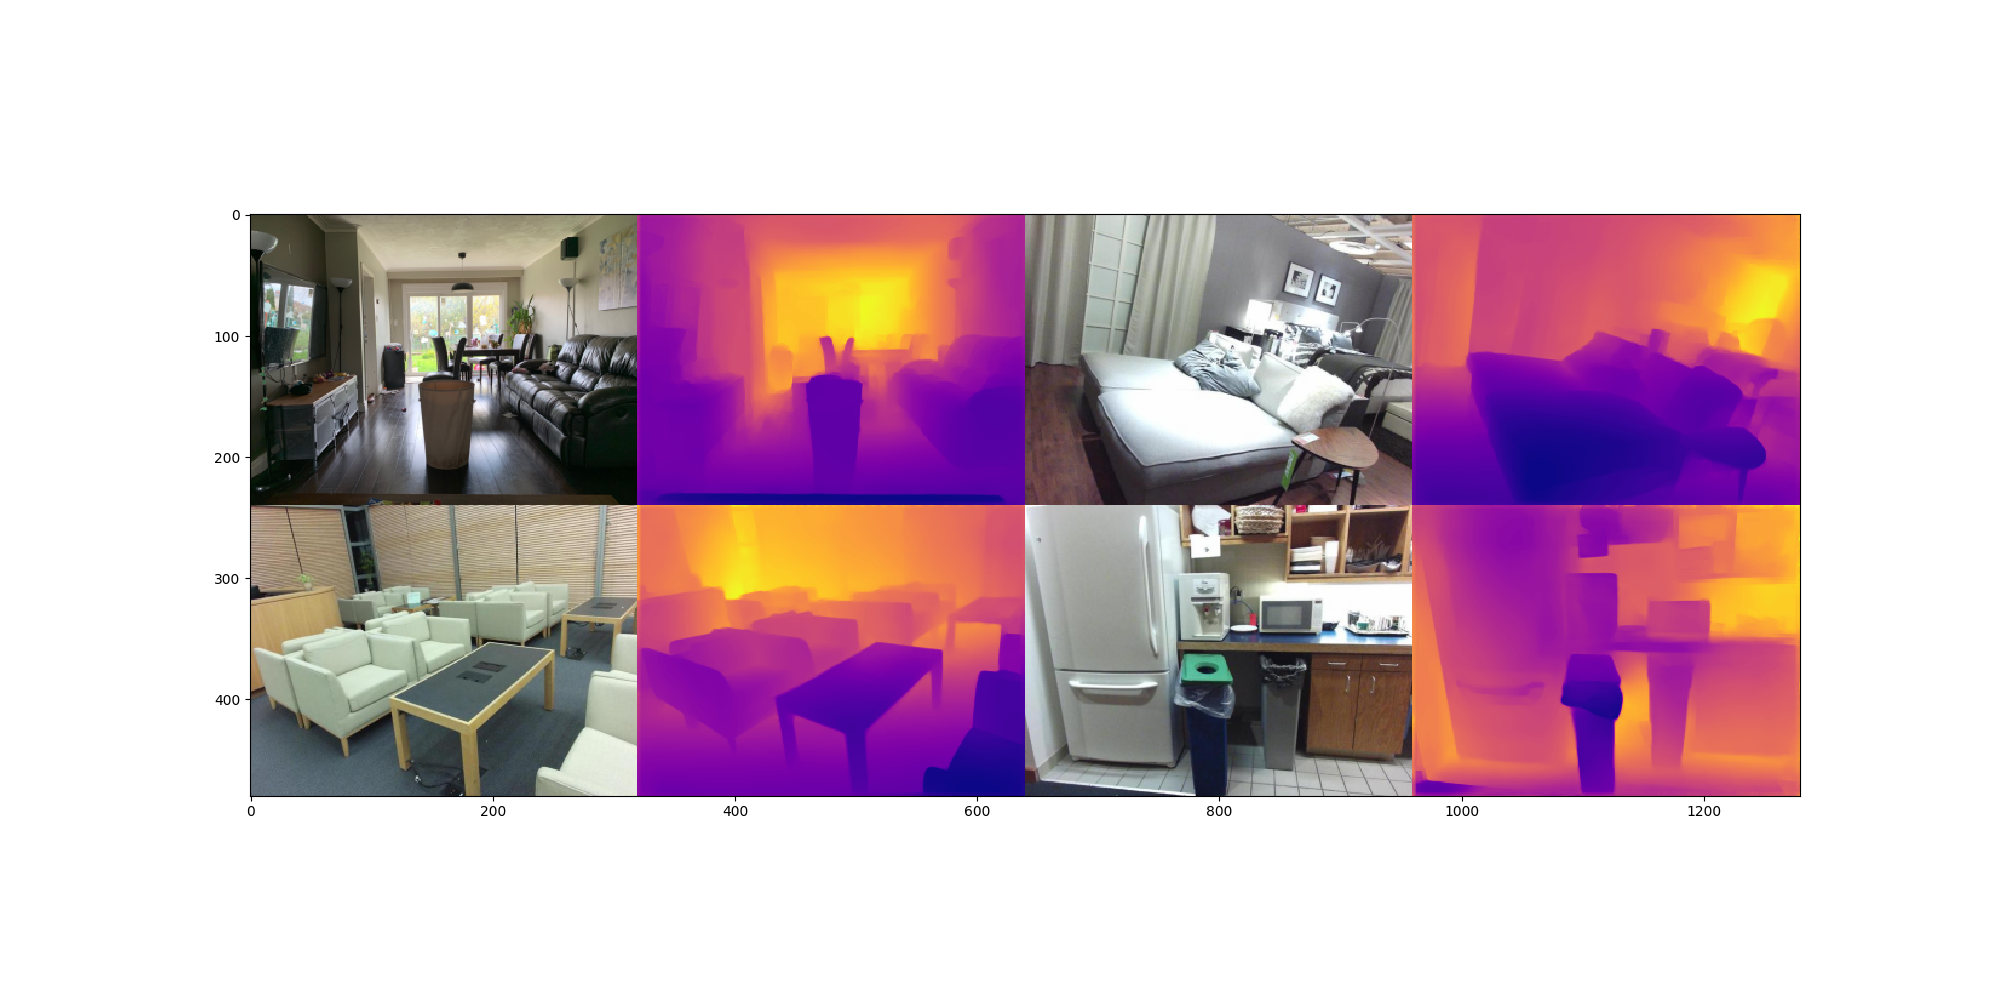

In [11]:
Image(filename="results.png") 

In [12]:
%cd Deep-Learning/depth_estimation
!dir

[Errno 2] No such file or directory: 'Deep-Learning/depth_estimation'
/content/Deep-Learning/depth_estimation
augment.py    image_results	 model.py	  nyu_test.zip	test_video.MOV
callbacks.py  image_results.mp4  model_resnet.py  __pycache__	test_video.py
data.py       __init__.py	 my_examples	  README.md	train.py
evaluate.py   layers.py		 nyu_data.zip	  results.png	utils.py
gif.gif       loss.py		 nyu.h5		  test.py


(480000,)


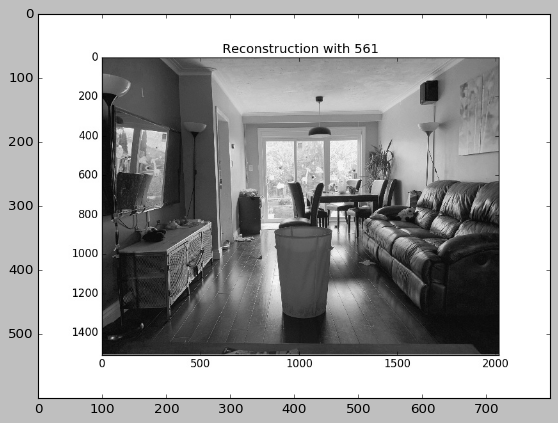

In [34]:
plt.style.use('classic')
img = Image.open('my_examples/test_IMG.jpg')
# convert to numpy array
imgmat = np.array(list(img.getdata(band=0)), float)
print(imgmat.shape)
# Reshape according to orginal image dimensions
imgmat.shape = (img.size[1], img.size[0])

plt.figure(figsize=(9, 6))
plt.imshow(img)
plt.show()

**Singular value decomposition**

In [0]:
#Import time module to time the cpu processing time for code execution
import time
# Import shutil to copy files
import shutil

# Create folder for results
!mkdir "result_folder"

In [0]:
U, D, V = np.linalg.svd(imgmat)

In [0]:
import os, shutil
folder = 'my_examples/'
for the_file in os.listdir(folder):
    file_path = os.path.join(folder, the_file)
    try:
        if os.path.isfile(file_path):
            os.unlink(file_path)
        #elif os.path.isdir(file_path): shutil.rmtree(file_path)
    except Exception as e:
        print(e)

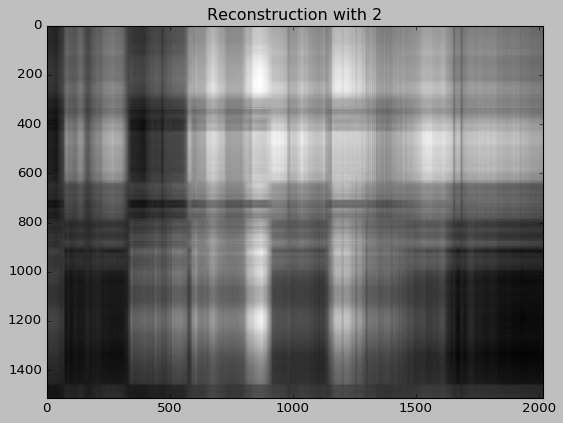

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (1) images of size (480, 640, 3).
It took:  26.919557809829712
Time for execution:  1.0017616480000022


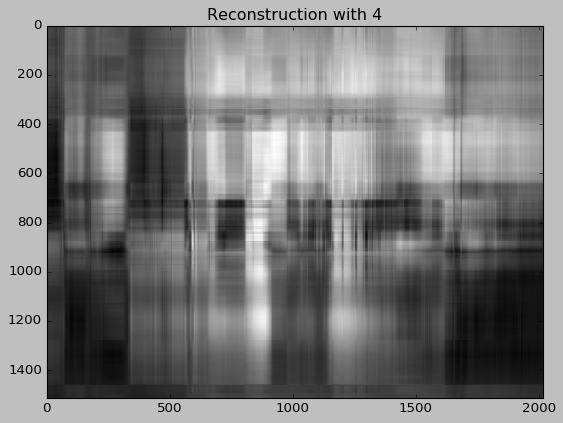

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (1) images of size (480, 640, 3).
It took:  26.82354187965393
Time for execution:  0.9933364309999995


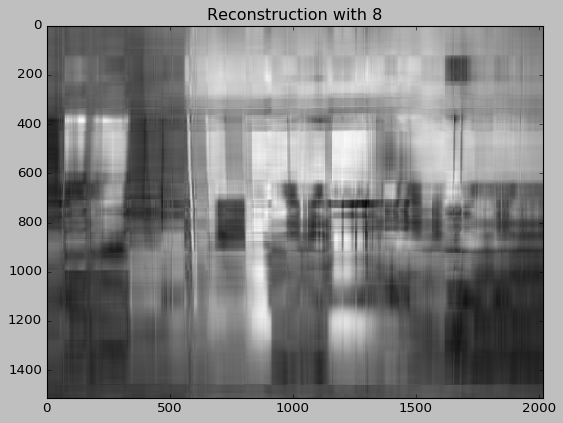

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (1) images of size (480, 640, 3).
It took:  26.881634950637817
Time for execution:  0.9942286440000032


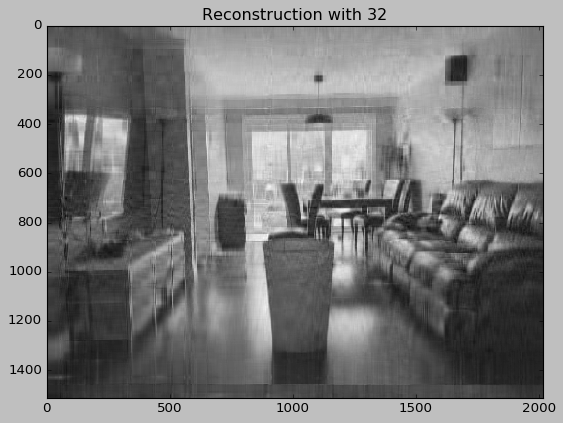

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (1) images of size (480, 640, 3).
It took:  26.848743200302124
Time for execution:  1.0240839040000012


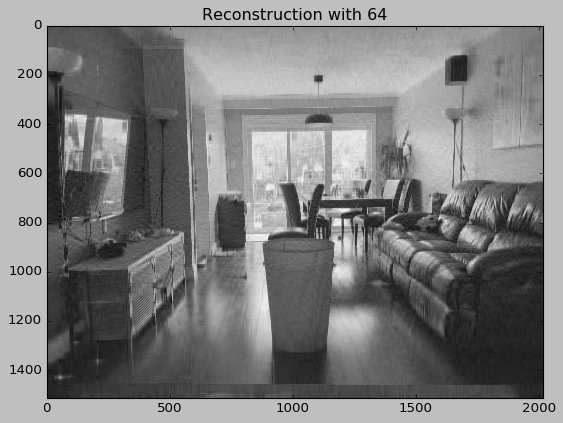

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (1) images of size (480, 640, 3).
It took:  26.771867513656616
Time for execution:  1.0612662150000034


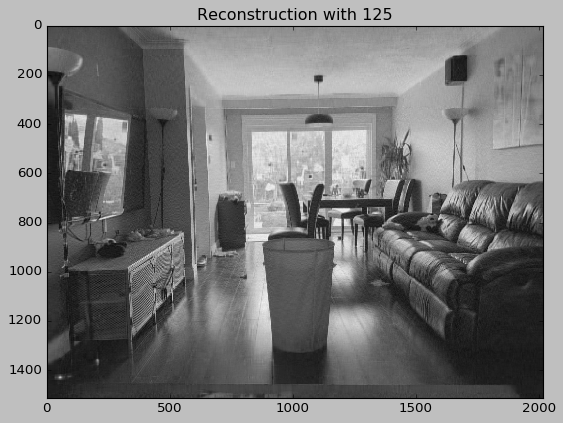

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (1) images of size (480, 640, 3).
It took:  26.658915996551514
Time for execution:  1.0773253549999993


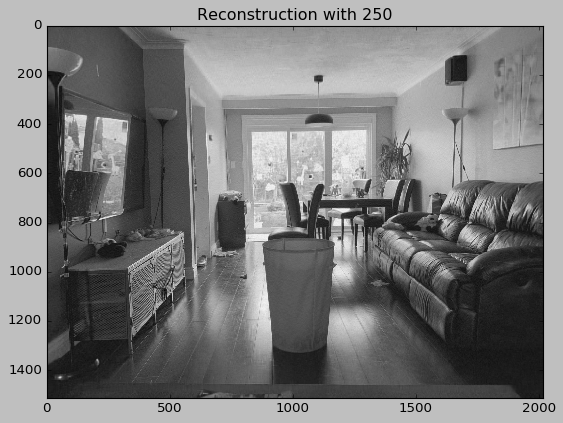

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (1) images of size (480, 640, 3).
It took:  26.815006971359253
Time for execution:  1.1118398569999997


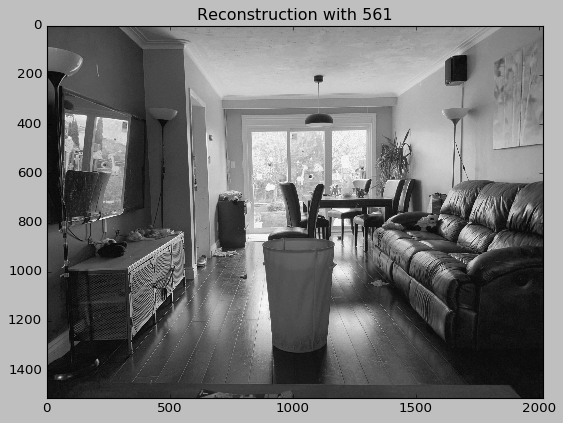

Using TensorFlow backend.
Loading model...















Model loaded (./nyu.h5).

Loaded (1) images of size (480, 640, 3).
It took:  26.670125722885132
Time for execution:  1.2504215689999967


In [25]:
#number_of_singular_values = 40
for number_of_singular_values in [2,4,8,32,64,125,250,561]:
  start = time.process_time()
  reconstimg = np.matrix(U[:, :number_of_singular_values]) * np.diag(D[:number_of_singular_values]) * np.matrix(V[:number_of_singular_values, :])
  plt.imshow(reconstimg, cmap='gray') #
  plt.title("Reconstruction with "+ str(number_of_singular_values))
  plt.savefig('my_examples/test_IMG.jpg')
  plt.show()
  !python test.py --model ./nyu.h5
  print("Time for execution: ",time.process_time() - start)
  # Copy result file to designated folder
  shutil.copy2('results.png', 'result_folder/'+'result_with_'+str(number_of_singular_values)+'_components.png')


**Run depth estimation**

In [0]:
!python test.py --model ./nyu.h5

In [0]:
from IPython.display import Image

Image(filename="results.png") 